In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

In [2]:
from sklearn.cross_validation import train_test_split

/Users/Patrick/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [13]:
df_train_var = pd.read_csv("Original_Data/training_variants")
df_test_var = pd.read_csv("Original_Data/test_variants")
df_train_txt = pd.read_csv('Original_Data/training_text', sep='\|\|', header=None, skiprows=1,names=["ID","Text"])
df_test_txt = pd.read_csv('Original_Data/test_text', sep='\|\|', header=None, skiprows=1,names=["ID","Text"])

/Users/Patrick/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  app.launch_new_instance()
/Users/Patrick/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


In [27]:
df_test_txt.to_pickle('df_test_txt.pkl')
df_train_txt.to_pickle('df_train_txt.pkl')
df_test_var.to_pickle('df_test_var.pkl')
df_train_var.to_pickle('df_train_var.pkl')

In [3]:
df_test_txt = pd.read_pickle('df_test_txt.pkl')
df_train_txt = pd.read_pickle('df_train_txt.pkl')
df_test_var = pd.read_pickle('df_test_var.pkl')
df_train_var = pd.read_pickle('df_train_var.pkl')

In [3]:
df_train_var['Variation'].unique()

array(['Truncating Mutations', 'W802*', 'Q249E', ..., 'A122*', 'R80C',
       'K83E'], dtype=object)

In [5]:
import re
from stop_words import get_stop_words

stop_words = get_stop_words('english')

def remove_pun(text):
    s = re.sub(r'[^\w\s\d]','',text)
    s = re.sub(r'[\s][\d]+[\s]', ' ', s)   
    s = ' '.join([w for w in s.split() if not w.lower() in stop_words])
    return s

sent = "string$%. sd 0.5 m*l With. 0.5 ad P145A Punctuation?"
sent = remove_pun(sent)
sent

'string sd ml ad P145A Punctuation'

In [6]:
df_train_txt['Text_cleaned'] = df_train_txt.Text.apply(remove_pun)
df_test_txt['Text_cleaned'] =  df_test_txt.Text.apply(remove_pun)

In [7]:
# merge text and var datasets
# training datasets 
train_master = pd.merge(df_train_var, df_train_txt, how='left', on='ID').fillna('')

# test datasets 
test_master = pd.merge(df_test_var, df_test_txt, how='left', on='ID').fillna('')

In [8]:
print(train_master.head())
print(test_master.head())

   ID    Gene             Variation  Class  \
0   0  FAM58A  Truncating Mutations      1   
1   1     CBL                 W802*      2   
2   2     CBL                 Q249E      2   
3   3     CBL                 N454D      3   
4   4     CBL                 L399V      4   

                                                Text  \
0  Cyclin-dependent kinases (CDKs) regulate a var...   
1   Abstract Background  Non-small cell lung canc...   
2   Abstract Background  Non-small cell lung canc...   
3  Recent evidence has demonstrated that acquired...   
4  Oncogenic mutations in the monomeric Casitas B...   

                                        Text_cleaned  
0  Cyclindependent kinases CDKs regulate variety ...  
1  Abstract Background Nonsmall cell lung cancer ...  
2  Abstract Background Nonsmall cell lung cancer ...  
3  Recent evidence demonstrated acquired uniparen...  
4  Oncogenic mutations monomeric Casitas Blineage...  
   ID     Gene Variation                                

In [59]:
#look at missingness

test_master.apply(lambda x: sum(x.isnull().values), axis = 0)

ID              0
Gene            0
Variation       0
Text            0
Text_cleaned    0
dtype: int64

### Doc2Vec

In [10]:
#import packages

import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import multiprocessing
import os

In [11]:
LabeledSentence = gensim.models.doc2vec.LabeledSentence

In [12]:
# train/test splits

X_train, X_test, y_train, y_test = train_test_split(train_master['Text_cleaned'], train_master['Class'], test_size=0.2, random_state=42)

In [13]:
X_new = test_master['Text_cleaned']

In [14]:
#Do some very minor text preprocessing
def preprocessText(corpus):
    corpus = [z.split() for z in corpus]
    return corpus

In [15]:
X_train = preprocessText(X_train)
X_test = preprocessText(X_test)
X_new = preprocessText(X_new)

In [16]:
assert gensim.models.doc2vec.FAST_VERSION > -1, "this will be painfully slow otherwise"

In [17]:
#Gensim's Doc2Vec implementation requires each document/paragraph to have a label associated with it.

#We do this by using the LabeledSentence method. The format will be "TRAIN_i" or "TEST_i" where "i" is
#a dummy index of the paper text.

def labelizePapers(papers, label_type):
    labelized = []
    for i,v in enumerate(papers):
        label = '%s_%s'%(label_type,i)
        labelized.append(LabeledSentence(v, [label]))
    return labelized

In [18]:
X_train = labelizePapers(X_train, 'TRAIN')
X_test = labelizePapers(X_test, 'TEST')
X_new = labelizePapers(X_new, 'UNSUP')

In [19]:
import itertools

In [20]:
#instantiate our DM and DBOW models
d2v_model_dm = gensim.models.Doc2Vec(min_count=3, window=7, size=400, sample=1e-3, negative=5, workers=cores)
d2v_model_dbow = gensim.models.Doc2Vec(min_count=3, window=7, size=400, sample=1e-3, negative=5, dm=0, workers=cores)


In [21]:
#build vocab over all reviews
X_all = X_train + X_test + X_new

d2v_model_dm.build_vocab(X_all)
d2v_model_dbow.build_vocab(X_all)


In [22]:
# train the DM model on the training set
# replace X_train with X_all
# WARNING: TAKES 2.25 HOURS TO RUN ON PMP'S COMPUTER

d2v_model_dm.train(X_all,
                   total_examples=d2v_model_dm.corpus_count,
                   epochs=d2v_model_dm.iter)


228822356

In [100]:
# train the DBOW model on training set

d2v_model_dbow.train(X_all,
                     total_examples=d2v_model_dbow.corpus_count,
                     epochs=d2v_model_dbow.iter)


65897595

In [23]:
d2v_model_dm.save('models/doc2vec_dm')

In [101]:
# save the two models
os.makedirs('models')
d2v_model_dm.save('models/doc2vec_dm')

d2v_model_dbow.save('models/doc2vec_dbow')

In [24]:
# infer DM vectors for training set and save to a list
# WARNING: TAKES 15 MINUTES ON PMP'S COMPUTER

train_vecs_dm = []

for doc in X_train:
    vec = d2v_model_dm.infer_vector(doc.words)
    train_vecs_dm.append(vec)


In [106]:
# infer DBOW vectors for training set and save to a list
train_vecs_dbow = []

for doc in X_train:
    vec = d2v_model_dbow.infer_vector(doc.words)
    train_vecs_dbow.append(vec)

In [107]:
# train the DM model on the test set

d2v_model_dm.train(X_test,
                   total_examples=d2v_model_dm.corpus_count,
                   epochs=d2v_model_dm.iter)

17322807

In [108]:
# train the DBOW model on test set

d2v_model_dbow.train(X_test,
                     total_examples=d2v_model_dbow.corpus_count,
                     epochs=d2v_model_dbow.iter)


17323012

In [25]:
# infer DM vectors for test set and save to a list
# WARNING: TAKES 5 MINS ON PMP'S COMPUTER

test_vecs_dm = []

for doc in X_test:
    vec = d2v_model_dm.infer_vector(doc.words)
    test_vecs_dm.append(vec)

In [110]:
# infer DBOW vectors for test set and save to a list

test_vecs_dbow = []

for doc in X_test:
    vec = d2v_model_dbow.infer_vector(doc.words)
    test_vecs_dbow.append(vec)

### SGD Classifier

In [34]:
from sklearn.linear_model import SGDClassifier

# train 

lr_dm = SGDClassifier(loss='log', penalty='l1', class_weight='balanced')
lr_dm.fit(train_vecs_dm, y_train)

print('DM Test Accuracy: %.2f'%lr_dm.score(test_vecs_dm, y_test))

/Users/Patrick/anaconda/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


DM Test Accuracy: 0.55


In [128]:
# save SGD model
import pickle

pickle.dump(lr_dm, open('models/sgd_dm_model.sav', 'wb'))

In [129]:
# read in the saved model
sgd_lm_model = pickle.load(open('models/sgd_dm_model.sav', 'rb'))

In [130]:
sgd_lm_model.score(test_vecs_dm, y_test)

0.55338345864661653

In [114]:
lr_dbow = SGDClassifier(loss='log', penalty='l1',class_weight='balanced')
lr_dbow.fit(train_vecs_dbow, y_train)

print('DBOW Test Accuracy: %.2f'%lr_dbow.score(test_vecs_dbow, y_test))

/Users/Patrick/anaconda/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


DBOW Test Accuracy: 0.47


In [35]:
# save the predicted classes
test_predict_dm = lr_dm.predict(test_vecs_dm)

In [30]:
import sklearn

In [36]:
print('confusion_matrix:\n', sklearn.metrics.confusion_matrix(y_test,test_predict_dm))

confusion_matrix:
 [[ 73   5   1  19   7   4   5   0   0]
 [  8  43   1   2   5   6  31   0   0]
 [  2   1  11   3   1   0   1   0   0]
 [ 34   7   5  78   5   5   5   0   0]
 [ 17   7   1   8  11   3   3   0   0]
 [  4   2   0   3   4  31   1   0   0]
 [  6  33   3  11  10  11 117   1   2]
 [  0   0   0   0   0   0   1   0   0]
 [  1   0   0   1   0   0   0   1   4]]


### Support Vector Classifier

In [39]:
from sklearn.svm import SVC

svm = SVC(class_weight='balanced') ### NOTE: balanced has worse score than 'None', but balanced better in theory
svm.fit(train_vecs_dm, y_train)

print('Accuracy score: ' + str(svm.score(test_vecs_dm, y_test)))
svm_pred = svm.predict(test_vecs_dm)

print('confusion_matrix:\n', sklearn.metrics.confusion_matrix(y_test,svm_pred))

Accuracy score: 0.609022556391
confusion_matrix:
 [[ 80   6   1  12  11   2   2   0   0]
 [  3  53   0   0   5   2  33   0   0]
 [  2   0  13   2   0   0   2   0   0]
 [ 43   6   4  69   9   2   6   0   0]
 [  9   3   1   3  25   4   5   0   0]
 [  4   3   0   1   3  32   2   0   0]
 [  3  42   9   3   9   0 128   0   0]
 [  0   0   0   0   0   0   1   0   0]
 [  0   1   0   0   1   0   0   0   5]]


In [131]:
# save SVM model

pickle.dump(svm, open('models/svm_dm_model.sav', 'wb'))

In [132]:
# read in the saved model
svm_lm_model = pickle.load(open('models/svm_dm_model.sav', 'rb'))

### Multinomial Logistic Classifier

In [54]:
## NOTE - next , do grid search on C (from 1e-4 to 1e5), multi-class

from sklearn.linear_model import LogisticRegression

multinomial = LogisticRegression(multi_class='ovr', ### one-vs-rest
                                 class_weight='balanced',
                                 solver='liblinear',
                                 penalty='l1',
                                 C=.1)

multinomial.fit(train_vecs_dm, y_train)
print('Accuracy score: ' + str(multinomial.score(test_vecs_dm, y_test)))
multinomial_pred = multinomial.predict(test_vecs_dm)

print('confusion_matrix:\n', sklearn.metrics.confusion_matrix(y_test,multinomial_pred))

Accuracy score: 0.595488721805
confusion_matrix:
 [[ 76   7   0  15   9   5   2   0   0]
 [  3  42   2   0   5   6  37   0   1]
 [  2   0  12   2   0   0   3   0   0]
 [ 27   2   3  76  13   7   8   0   3]
 [ 12   3   1   7  18   4   5   0   0]
 [  5   0   1   3   2  31   3   0   0]
 [  3  25  10   5  11   1 137   1   1]
 [  0   0   0   0   0   0   1   0   0]
 [  0   1   0   0   1   0   0   1   4]]


In [133]:
# save Multinomial Logistic Classification model

pickle.dump(multinomial, open('models/multinomiallog_dm_model.sav', 'wb'))

In [134]:
# read in the saved model
multinomiallog_lm_model = pickle.load(open('models/multinomiallog_dm_model.sav', 'rb'))

In [45]:
# Multinomial Logistic CLassifier with 10 fold CV on C
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score

#CV
C_range = [.0001,.001,.01,.1,1,10,100,1000,10000]

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for c in C_range:
    multinomial = LogisticRegression(multi_class='ovr', 
                                 class_weight='balanced',
                                 solver='liblinear',
                                 penalty='l1',
                                 C=c)
    scores = cross_val_score(multinomial, train_vecs_dm, y_train, cv=10)
    cv_scores.append(scores.mean())

In [46]:
optimal_C = C_range[cv_scores.index(max(cv_scores))]
optimal_C

0.1

In [55]:
cv_scores

[0.17093229881377797,
 0.28687536391160434,
 0.40138085735626594,
 0.5530753109253852,
 0.52669123513238547,
 0.480764825222881,
 0.47471393406455975,
 0.47470830383856877,
 0.47281854403305906]

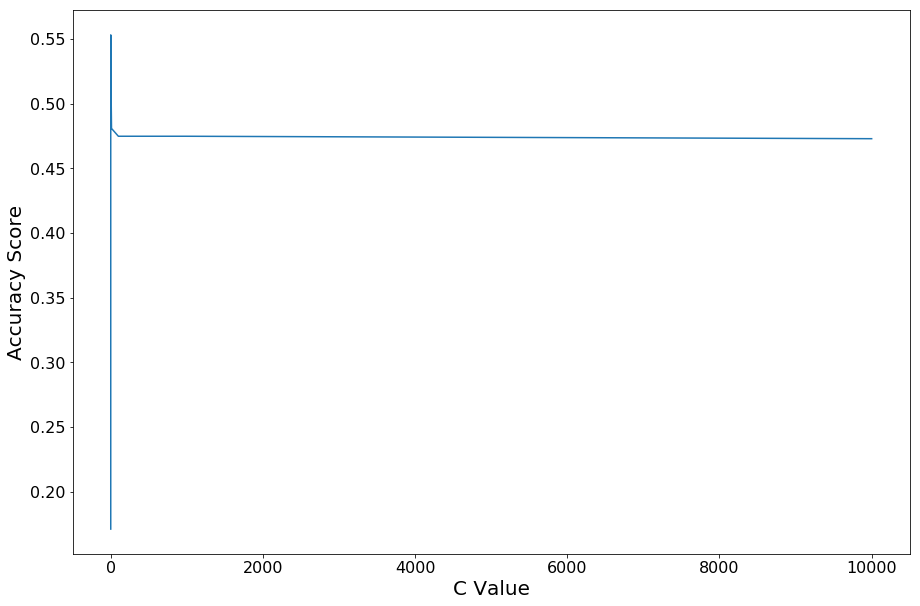

In [51]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))
plt.plot(C_range, cv_scores)
plt.xlabel('C Value', fontsize = 20)
plt.ylabel('Accuracy Score', fontsize = 20)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)

plt.show()
#plt.savefig('knn_cross_valid.png')

### Random Forest

In [68]:
# RF single shot

from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_jobs=-1,
                            random_state=51,
                            n_estimators=900,  ### do gridsearch >100
                            max_depth=40,
                            min_samples_leaf=5,  
                            oob_score=True,
                            class_weight='balanced'
                           )

rf.fit(train_vecs_dm, y_train)
print('Accuracy score: ' + str(rf.score(test_vecs_dm, y_test)))
rf_pred = rf.predict(test_vecs_dm)

print('confusion_matrix:\n', sklearn.metrics.confusion_matrix(y_test,rf_pred))

Accuracy score: 0.639097744361
confusion_matrix:
 [[ 73   2   0  16   9   1  13   0   0]
 [  4  32   0   0   4   1  55   0   0]
 [  2   0   9   2   0   0   6   0   0]
 [ 35   1   1  81   5   1  15   0   0]
 [ 11   1   0   8  18   3   9   0   0]
 [  6   0   0   1   1  31   6   0   0]
 [  1   8   3   3   3   0 176   0   0]
 [  0   0   0   0   0   0   1   0   0]
 [  0   0   0   0   1   0   1   0   5]]


In [70]:
# RF Grid Search CV

rf_params = {'n_estimators':[900],
              'max_depth':[20,30,40],
              'max_features':[15,20,25],
              'min_samples_leaf':[5,10,15]
             }

rf = RandomForestClassifier(n_jobs=-1,
                            random_state=51,
                            oob_score=True,
                            class_weight='balanced'
                           )

rf_cv = GridSearchCV(rf,
                     param_grid=rf_params,
                     cv=5)

rf_cv.fit(train_vecs_dm, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=-1, oob_score=True, random_state=51,
            verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'min_samples_leaf': [5, 10, 15], 'n_estimators': [900], 'max_features': [15, 20, 25], 'max_depth': [20, 30, 40]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [71]:
print(rf_cv.best_params_)

{'min_samples_leaf': 5, 'max_features': 15, 'n_estimators': 900, 'max_depth': 20}


In [72]:
y_rf_pred = rf_cv.best_estimator_.predict(test_vecs_dm)

In [73]:
print('Accuracy score: ' + str(rf_cv.best_estimator_.score(test_vecs_dm, y_test)))

print('confusion_matrix:\n', sklearn.metrics.confusion_matrix(y_test,y_rf_pred))

Accuracy score: 0.640601503759
confusion_matrix:
 [[ 77   2   0  12   8   2  13   0   0]
 [  3  32   0   0   4   1  56   0   0]
 [  2   0   9   2   0   0   6   0   0]
 [ 31   1   1  82   5   1  18   0   0]
 [ 14   0   0   7  16   3  10   0   0]
 [  6   0   0   1   1  31   6   0   0]
 [  2   9   3   3   3   0 174   0   0]
 [  0   0   0   0   0   0   1   0   0]
 [  0   0   0   0   1   0   1   0   5]]


In [135]:
# save RF model

pickle.dump(rf_cv.best_estimator_, open('models/rf_dm_model.sav', 'wb'))

In [136]:
# read in the saved model
rf_lm_model = pickle.load(open('models/rf_dm_model.sav', 'rb'))

### Gradient Boosting Model

In [75]:
# GBM single shot

from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(learning_rate=.01,
                                random_state=13,
                                n_estimators=600,
                                max_features=15,
                                max_depth=20,
                                min_samples_leaf=5
                               )

gb.fit(train_vecs_dm, y_train)
print('Accuracy score: ' + str(gb.score(test_vecs_dm, y_test)))
gb_pred = gb.predict(test_vecs_dm)

print('confusion_matrix:\n', sklearn.metrics.confusion_matrix(y_test,gb_pred))

Accuracy score: 0.651127819549
confusion_matrix:
 [[ 85   2   0  16   5   1   5   0   0]
 [  4  29   0   0   4   1  58   0   0]
 [  2   0   4   3   0   0  10   0   0]
 [ 31   0   0  91   1   1  15   0   0]
 [ 17   0   0  11  10   2  10   0   0]
 [  6   0   0   1   1  31   6   0   0]
 [  1   6   1   4   2   0 180   0   0]
 [  0   0   0   0   0   0   1   0   0]
 [  1   0   0   0   1   0   2   0   3]]


In [138]:
# save GBM model

pickle.dump(gb, open('models/gbm_dm_model.sav', 'wb'))

In [139]:
# read in the saved model
gbm_lm_model = pickle.load(open('models/gbm_dm_model.sav', 'rb'))

In [ ]:
# GBM grid search CV

parameters = {'n_estimators':[600,700,800],
              'learning_rate':[0.01,0.03,0.05]
             }


gb_reg = GradientBoostingClassifier(random_state=13,
                                    n_jobs=-1,
                                    max_depth=30,
                                    min_samples_leaf=5
                                   )

gb_cv = GridSearchCV(gb_reg,
                     param_grid=parameters,
                     cv=5)

gb_cv.fit(train_vecs_dm, y_train)

### Multinomial Naive Bayes
#### Note: this is tough for Doc2Vec because some of the features (doc similarity vectors) are negative,
#### and MNB doesn't take negative inputs, so we have to scale them

In [89]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaler.fit(train_vecs_dm)
train_vecs_dm_scaled = scaler.transform(train_vecs_dm)

scaler.fit(test_vecs_dm)
test_vecs_dm_scaled = scaler.transform(test_vecs_dm)


In [91]:
# MNB single shot

from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB()

mnb.fit(train_vecs_dm_scaled, y_train)
print('Accuracy score: ' + str(mnb.score(test_vecs_dm_scaled, y_test)))
mnb_pred = mnb.predict(test_vecs_dm_scaled)

print('confusion_matrix:\n', sklearn.metrics.confusion_matrix(y_test,mnb_pred))

Accuracy score: 0.485714285714
confusion_matrix:
 [[ 40   0   0  24   4   1  45   0   0]
 [  0   0   0   0   0   0  96   0   0]
 [  2   0   0   4   2   0  11   0   0]
 [ 27   0   0  57   5   0  50   0   0]
 [  6   0   0  11  14   5  14   0   0]
 [  0   0   0   6   0  21  18   0   0]
 [  3   0   0   3   0   0 188   0   0]
 [  0   0   0   0   0   0   1   0   0]
 [  0   0   0   0   0   0   4   0   3]]


In [140]:
# save Multinomial Naive Bayes model

pickle.dump(mnb, open('models/mnb_dm_model.sav', 'wb'))

In [141]:
# read in the saved model
mnb_lm_model = pickle.load(open('models/mnb_dm_model.sav', 'rb'))

### Gaussian Naive Bayes
#### Can take negative inputs

In [92]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()

gnb.fit(train_vecs_dm, y_train)
print('Accuracy score: ' + str(gnb.score(test_vecs_dm, y_test)))
gnb_pred = gnb.predict(test_vecs_dm)

print('confusion_matrix:\n', sklearn.metrics.confusion_matrix(y_test,gnb_pred))


Accuracy score: 0.494736842105
confusion_matrix:
 [[ 57   9   5  19  18   2   3   1   0]
 [  2  43   8   8   4   1  30   0   0]
 [  2   0  15   1   0   0   1   0   0]
 [ 55   5  14  41  11   1  11   1   0]
 [ 10   3   1   4  24   3   5   0   0]
 [  4   2   2   3   0  29   5   0   0]
 [  6  39  19   6   4   2 116   2   0]
 [  0   0   0   0   0   0   1   0   0]
 [  0   1   0   0   1   0   0   1   4]]


In [142]:
# save Gaussian Naive Bayes model

pickle.dump(gnb, open('models/gnb_dm_model.sav', 'wb'))

In [143]:
# read in the saved model
gnb_lm_model = pickle.load(open('models/gnb_dm_model.sav', 'rb'))

### XGBoost

In [118]:
# Convert the train_vecs_dm and test_vecs_dm lists of np arrays to pd dfs for XGBoost

nrow_train = list(range(len(train_vecs_dm)))
nrow_test = list(range(len(test_vecs_dm)))

df_4 = pd.DataFrame.from_items(zip(nrow_train, train_vecs_dm))
xgb_train_vecs_dm = pd.DataFrame.transpose(df_4)

df_5 = pd.DataFrame.from_items(zip(nrow_test, test_vecs_dm))
xgb_test_vecs_dm = pd.DataFrame.transpose(df_5)

In [117]:
type(y_train)

pandas.core.series.Series

In [120]:
import xgboost as xgb

xgbtrain = xgb.DMatrix(xgb_train_vecs_dm.values)
xgbtest = xgb.DMatrix(xgb_test_vecs_dm.values)

In [125]:
type(xgb_train_vecs_dm)

pandas.core.frame.DataFrame

In [126]:
from xgboost import XGBClassifier

xgb = XGBClassifier(seed=25,
                    max_depth=15,
                    learning_rate=.01,
                    n_estimators=1000,
                    subsample = .85,
                    colsample_bytree = .7,
                    reg_alpha = 0,
                    reg_lambda = 1)

xgb.fit(xgb_train_vecs_dm, y_train)
print('Accuracy score: ' + str(xgb.score(xgb_test_vecs_dm, y_test)))
xgb_pred = xgb.predict(xgb_test_vecs_dm)

print('confusion_matrix:\n', sklearn.metrics.confusion_matrix(y_test,xgb_pred))


Accuracy score: 0.666165413534
confusion_matrix:
 [[ 83   2   0  18   4   2   5   0   0]
 [  5  33   0   0   5   1  52   0   0]
 [  2   0   6   3   0   0   8   0   0]
 [ 29   2   0  97   1   1   9   0   0]
 [ 15   1   0  13  10   2   9   0   0]
 [  6   0   0   2   1  30   6   0   0]
 [  1   8   1   2   3   0 179   0   0]
 [  0   0   0   0   0   0   1   0   0]
 [  0   0   0   0   1   0   1   0   5]]


In [144]:
# save XGBoost model

pickle.dump(xgb, open('models/xgb_dm_model.sav', 'wb'))

In [146]:
# read in the saved model
xgb_lm_model = pickle.load(open('models/xgb_dm_model.sav', 'rb'))

In [147]:
# testing model saved in file

print('Accuracy score: ' + str(xgb_lm_model.score(xgb_test_vecs_dm, y_test)))
xgb_pred = xgb_lm_model.predict(xgb_test_vecs_dm)

print('confusion_matrix:\n', sklearn.metrics.confusion_matrix(y_test,xgb_pred))

Accuracy score: 0.666165413534
confusion_matrix:
 [[ 83   2   0  18   4   2   5   0   0]
 [  5  33   0   0   5   1  52   0   0]
 [  2   0   6   3   0   0   8   0   0]
 [ 29   2   0  97   1   1   9   0   0]
 [ 15   1   0  13  10   2   9   0   0]
 [  6   0   0   2   1  30   6   0   0]
 [  1   8   1   2   3   0 179   0   0]
 [  0   0   0   0   0   0   1   0   0]
 [  0   0   0   0   1   0   1   0   5]]


In [ ]:
### CODE FOR LOADING A MODEL

doc2vec_model = Doc2Vec.load('models/doc2vec.model')

In [149]:
pickle.dump(train_vecs_dm, open('train_vecs_dm.pkl', 'wb'))

In [150]:
pickle.dump(test_vecs_dm, open('test_vecs_dm.pkl', 'wb'))

In [151]:
testtt = pd.read_pickle('train_vecs_dm.pkl')